# YOLO Overnight Pipeline (Train + Validate + Preview Video)

This notebook exports SoccerNetGS labels into a YOLO dataset (`prepared_yolo/`), trains a YOLO model, runs validation, saves key metrics, and generates a `val_preview.mp4` for a chosen validation clip.

Assumes SoccerNetGS is already downloaded/unzipped under `data/SoccerNetGS/`.


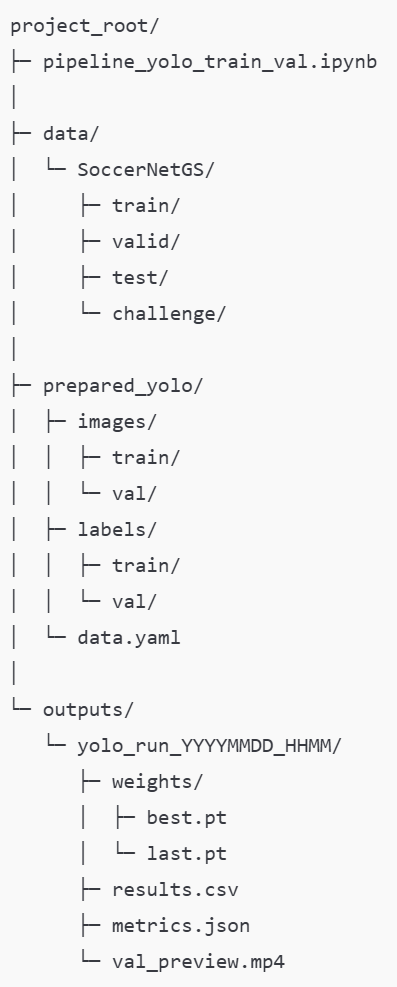

In [20]:
# Cell 1 — Config (edit these only)

from pathlib import Path
import os, json, shutil, time
from datetime import datetime
from collections import defaultdict

# -------- Paths (project root = where this notebook lives) --------
PROJECT_ROOT = Path(".").resolve()
DATA_ROOT    = PROJECT_ROOT / "data" / "SoccerNetGS"

PREPARED_DIR = PROJECT_ROOT / "prepared_yolo"
OUTPUTS_DIR  = PROJECT_ROOT / "outputs"

# -------- Export settings --------
KEEP_NAMES = ["player", "goalkeeper", "referee", "ball", "other"]  # your YOLO classes
FRAME_STRIDE_EXPORT = 5       # set to 2/5 if you want fewer frames (faster, smaller dataset)
TRAIN_MAX_CLIPS = 10        # None = all clips; or integer for quick tests
VALID_MAX_CLIPS = 5        # None = all clips; or integer for quick tests

MIN_BOX_AREA = 10             # filter tiny boxes (in pixels^2); adjust if needed
PAD = 0                       # optional padding around bbox for export (usually 0 for detection)

# -------- Training settings --------
BASE_MODEL = "yolov8n.pt"      # or your custom starting weights
IMGSZ = 640                    # you used 960 previously; 640 is faster
EPOCHS = 10                    # overnight: 30–100 depending on time
BATCH = 8                      # adjust for your GPU/CPU memory
WORKERS = 0
DEVICE = "cpu"                     # 0 for GPU, "cpu" for CPU, or "0" etc.

# -------- Preview video settings --------
PREVIEW_CLIP_ID = "SNGS-021"   # must exist under data/SoccerNetGS/valid/<CLIP_ID>
PREVIEW_CONF = 0.25
PREVIEW_STRIDE = 1            # set 2/5 for faster video generation
PREVIEW_FPS = 25

# -------- Run folder (unique per run) --------
RUN_NAME = datetime.now().strftime("yolo_run_%Y%m%d_%H%M")
RUN_DIR = OUTPUTS_DIR / RUN_NAME

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_ROOT:", DATA_ROOT)
print("PREPARED_DIR:", PREPARED_DIR)
print("RUN_DIR:", RUN_DIR)


PROJECT_ROOT: C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project
DATA_ROOT: C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project\data\SoccerNetGS
PREPARED_DIR: C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project\prepared_yolo
RUN_DIR: C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project\outputs\yolo_run_20260119_2246


## Step 1 — Helper functions (export + YAML + preview video)

This cell defines:
- a YOLO dataset exporter from SoccerNetGS `Labels-GameState.json`
- a writer for `prepared_yolo/data.yaml`
- a small helper to render a `val_preview.mp4` using YOLO predictions


In [21]:
# Cell 2 — Helpers

import cv2
import numpy as np

def list_label_files(data_root: Path, split: str, max_clips=None):
    split_dir = data_root / split
    files = sorted(split_dir.rglob("Labels-GameState.json"))
    if max_clips is not None:
        files = files[:max_clips]
    return files

def crop_xywh(img, x, y, w, h, pad=0):
    H, W = img.shape[:2]
    x1 = int(max(0, x - pad))
    y1 = int(max(0, y - pad))
    x2 = int(min(W - 1, x + w + pad))
    y2 = int(min(H - 1, y + h + pad))
    if x2 <= x1 or y2 <= y1:
        return None
    return img[y1:y2, x1:x2]

import os
import stat
import time
import shutil
from pathlib import Path

def _rmtree_onerror(func, path, exc_info):
    """
    Windows fix: if a file/dir is read-only, make it writable then retry.
    """
    try:
        os.chmod(path, stat.S_IWRITE)
    except Exception:
        pass
    func(path)

def reset_prepared_dir(prepared_dir: Path, retries: int = 5, sleep_s: float = 0.5):
    """
    Robust delete/recreate for Windows. Retries to handle transient locks.
    """
    prepared_dir = Path(prepared_dir)

    if prepared_dir.exists():
        last_err = None
        for _ in range(retries):
            try:
                shutil.rmtree(prepared_dir, onerror=_rmtree_onerror)
                last_err = None
                break
            except PermissionError as e:
                last_err = e
                time.sleep(sleep_s)

        if last_err is not None:
            raise last_err

    (prepared_dir / "images" / "train").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "images" / "val").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "labels" / "train").mkdir(parents=True, exist_ok=True)
    (prepared_dir / "labels" / "val").mkdir(parents=True, exist_ok=True)


def write_data_yaml(prepared_dir: Path, keep_names):
    data_yaml = prepared_dir / "data.yaml"
    names = {i: n for i, n in enumerate(keep_names)}
    content = {
        "path": str(prepared_dir).replace("\\", "/"),
        "train": "images/train",
        "val": "images/val",
        "names": names
    }
    # Write YAML manually (simple + avoids PyYAML dependency)
    lines = []
    lines.append(f'path: "{content["path"]}"')
    lines.append(f'train: {content["train"]}')
    lines.append(f'val: {content["val"]}')
    lines.append("names:")
    for k, v in names.items():
        lines.append(f"  {k}: {v}")
    data_yaml.write_text("\n".join(lines) + "\n", encoding="utf-8")
    return data_yaml

def export_split_to_yolo(
    src_split: str, dst_split: str,
    data_root: Path, prepared_dir: Path,
    keep_names,
    frame_stride: int = 1,
    max_clips=None,
    min_box_area: int = 10,
    pad: int = 0,
):
    label_files = list_label_files(data_root, src_split, max_clips=max_clips)
    print(f"{src_split}: using {len(label_files)} clips")

    name_to_yolo = {n: i for i, n in enumerate(keep_names)}
    saved_images = 0
    saved_labels = 0
    skipped = defaultdict(int)

    for labels_path in label_files:
        seq_dir = labels_path.parent
        clip_id = seq_dir.name

        labels = json.loads(labels_path.read_text(encoding="utf-8"))
        cat_id_to_name = {c["id"]: c["name"] for c in labels["categories"]}

        # image_id -> filename
        img_id_to_name = {im["image_id"]: im["file_name"] for im in labels["images"]}
        img_dir = seq_dir / labels["info"]["im_dir"]  # usually img1

        # group annotations per frame
        anns_by_img = defaultdict(list)
        for a in labels["annotations"]:
            if a.get("supercategory") != "object":
                continue

            cat_name = cat_id_to_name.get(a.get("category_id"))
            if cat_name is None:
                skipped["unknown_category"] += 1
                continue

            # map SoccerNetGS categories into keep set
            # everything not in KEEP_NAMES becomes "other" if "other" exists
            if cat_name not in name_to_yolo:
                if "other" in name_to_yolo:
                    cat_name = "other"
                else:
                    skipped["dropped_category"] += 1
                    continue

            b = a.get("bbox_image")
            if not b:
                skipped["missing_bbox"] += 1
                continue

            x, y, w, h = b["x"], b["y"], b["w"], b["h"]
            if w * h < min_box_area:
                skipped["too_small"] += 1
                continue

            anns_by_img[a["image_id"]].append((cat_name, x, y, w, h))

        # export frame by frame
        img_ids_sorted = sorted(img_id_to_name.keys())
        for idx, img_id in enumerate(img_ids_sorted):
            if frame_stride > 1 and (idx % frame_stride != 0):
                continue

            fname = img_id_to_name.get(img_id)
            if not fname:
                skipped["missing_frame_name"] += 1
                continue

            frame_path = img_dir / fname
            if not frame_path.exists():
                skipped["missing_frame_file"] += 1
                continue

            frame = cv2.imread(str(frame_path))
            if frame is None:
                skipped["bad_imread"] += 1
                continue

            H, W = frame.shape[:2]
            frame_stem = Path(fname).stem

            # output paths
            out_img_name = f"{clip_id}_{frame_stem}.jpg"
            out_lbl_name = f"{clip_id}_{frame_stem}.txt"

            out_img_path = prepared_dir / "images" / dst_split / out_img_name
            out_lbl_path = prepared_dir / "labels" / dst_split / out_lbl_name

            # write labels in YOLO format (one txt per image)
            lines = []
            for (cat_name, x, y, w, h) in anns_by_img.get(img_id, []):
                cls = name_to_yolo[cat_name]

                # YOLO wants: x_center, y_center, width, height normalized to [0,1]
                xc = (x + w / 2.0) / W
                yc = (y + h / 2.0) / H
                wn = w / W
                hn = h / H

                # clamp just in case
                xc = max(0.0, min(1.0, xc))
                yc = max(0.0, min(1.0, yc))
                wn = max(0.0, min(1.0, wn))
                hn = max(0.0, min(1.0, hn))

                lines.append(f"{cls} {xc:.6f} {yc:.6f} {wn:.6f} {hn:.6f}")

            # if no objects, still write empty label file (YOLO supports it)
            out_lbl_path.write_text("\n".join(lines) + ("\n" if lines else ""), encoding="utf-8")
            cv2.imwrite(str(out_img_path), frame)

            saved_images += 1
            saved_labels += len(lines)

    print(f"{dst_split}: saved_images={saved_images}, total_labels={saved_labels}")
    print("skipped:", dict(skipped))
    return {"saved_images": saved_images, "total_labels": saved_labels, "skipped": dict(skipped)}

def ensure_run_dirs(run_dir: Path):
    (run_dir / "weights").mkdir(parents=True, exist_ok=True)

def make_yolo_clip_video(model, clip_dir: Path, out_mp4: Path, conf=0.25, frame_stride=1, fps=25):
    clip_dir = Path(clip_dir)
    img_dir = clip_dir / "img1"
    frame_paths = sorted(img_dir.glob("*.jpg"))
    if not frame_paths:
        raise RuntimeError(f"No frames found in {img_dir}")

    first = cv2.imread(str(frame_paths[0]))
    if first is None:
        raise RuntimeError("Could not read first frame")
    H, W = first.shape[:2]

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(str(out_mp4), fourcc, fps, (W, H))

    for i, fp in enumerate(frame_paths):
        if frame_stride > 1 and (i % frame_stride != 0):
            continue

        frame = cv2.imread(str(fp))
        if frame is None:
            continue

        results = model.predict(source=frame, conf=conf, verbose=False)
        annotated = results[0].plot()  # Ultralytics draws boxes/classes
        vw.write(annotated)

    vw.release()
    print("✅ wrote preview video:", out_mp4)


## Step 2 — Export YOLO dataset to `prepared_yolo/`

This cell:
- wipes and rebuilds `prepared_yolo/`
- exports **all** (or limited) clips from:
  - `data/SoccerNetGS/train` → `prepared_yolo/images/train` + `labels/train`
  - `data/SoccerNetGS/valid` → `prepared_yolo/images/val` + `labels/val`
- writes `prepared_yolo/data.yaml` for Ultralytics


In [ ]:
# Cell 3 — Export dataset

reset_prepared_dir(PREPARED_DIR)

train_stats = export_split_to_yolo(
    src_split="train",
    dst_split="train",
    data_root=DATA_ROOT,
    prepared_dir=PREPARED_DIR,
    keep_names=KEEP_NAMES,
    frame_stride=FRAME_STRIDE_EXPORT,
    max_clips=TRAIN_MAX_CLIPS,
    min_box_area=MIN_BOX_AREA,
    pad=PAD,
)

val_stats = export_split_to_yolo(
    src_split="valid",
    dst_split="val",
    data_root=DATA_ROOT,
    prepared_dir=PREPARED_DIR,
    keep_names=KEEP_NAMES,
    frame_stride=FRAME_STRIDE_EXPORT,
    max_clips=VALID_MAX_CLIPS,
    min_box_area=MIN_BOX_AREA,
    pad=PAD,
)

data_yaml_path = write_data_yaml(PREPARED_DIR, KEEP_NAMES)

print("✅ Export done")
print("data.yaml:", data_yaml_path)
print("train_stats:", train_stats)
print("val_stats:", val_stats)


train: using 10 clips


## Step 3 — Train YOLO (outputs saved under `outputs/yolo_run_.../`)

This cell:
- creates a new unique run folder in `outputs/`
- runs `model.train(...)`
- copies `best.pt`, `last.pt` into `outputs/.../weights/`
- copies `results.csv` into `outputs/.../results.csv`


In [ ]:
# Cell 4 — Train YOLO and save key artifacts

from ultralytics import YOLO

OUTPUTS_DIR.mkdir(parents=True, exist_ok=True)
RUN_DIR.mkdir(parents=True, exist_ok=True)
ensure_run_dirs(RUN_DIR)

print("Training run folder:", RUN_DIR)

model = YOLO(BASE_MODEL)

# Force Ultralytics to write inside our RUN_DIR (it will create a subfolder)
train_results = model.train(
    data=str(PREPARED_DIR / "data.yaml"),
    imgsz=IMGSZ,
    epochs=EPOCHS,
    batch=BATCH,
    workers=WORKERS,
    device=DEVICE,
    project=str(RUN_DIR),
    name="ultralytics",   # Ultralytics will write to RUN_DIR/ultralytics/
)

ULTRA_DIR = RUN_DIR / "ultralytics"
print("Ultralytics output dir:", ULTRA_DIR)

# Find where Ultralytics actually wrote (usually RUN_DIR/ultralytics/)
# Common path: RUN_DIR/ultralytics/weights/best.pt, last.pt
best_pt = ULTRA_DIR / "weights" / "best.pt"
last_pt = ULTRA_DIR / "weights" / "last.pt"
results_csv = ULTRA_DIR / "results.csv"

# Copy into our minimal outputs
if best_pt.exists():
    shutil.copy2(best_pt, RUN_DIR / "weights" / "best.pt")
if last_pt.exists():
    shutil.copy2(last_pt, RUN_DIR / "weights" / "last.pt")
if results_csv.exists():
    shutil.copy2(results_csv, RUN_DIR / "results.csv")

print("✅ Copied key artifacts to:", RUN_DIR)
print(" -", RUN_DIR / "weights" / "best.pt")
print(" -", RUN_DIR / "weights" / "last.pt")
print(" -", RUN_DIR / "results.csv")


Training run folder: C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project\outputs\yolo_run_20260119_2215
Ultralytics 8.4.6  Python-3.13.3 torch-2.9.1+cu126 CPU (Snapdragon X 12-core X1E80100 @ 3.40 GHz)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\gerry\OneDrive\ESSEC-CS\M2\Foundations_Deep_Learning\Project\prepared_yolo\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=trai

KeyboardInterrupt: 

## Step 4 — Validate + save `metrics.json`

This cell:
- loads `best.pt`
- runs `model.val(...)` on the exported validation set
- writes a small `metrics.json` into the run folder with key values (mAP, precision, recall)


In [ ]:
# Cell 5 — Validate and write metrics.json

best_path = RUN_DIR / "weights" / "best.pt"
assert best_path.exists(), f"Missing best.pt at {best_path}"

best_model = YOLO(str(best_path))

val_metrics = best_model.val(
    data=str(PREPARED_DIR / "data.yaml"),
    split="val",
    imgsz=IMGSZ,
    device=DEVICE,
    verbose=False
)

# Ultralytics metrics objects can vary slightly by version.
# These are the common ones for detection:
summary = {}
try:
    summary["map50"] = float(val_metrics.box.map50)
    summary["map50_95"] = float(val_metrics.box.map)
    summary["precision"] = float(val_metrics.box.mp)
    summary["recall"] = float(val_metrics.box.mr)
except Exception as e:
    summary["error"] = f"Could not read standard metrics fields: {e}"
    summary["raw"] = str(val_metrics)

metrics_path = RUN_DIR / "metrics.json"
metrics_path.write_text(json.dumps(summary, indent=2), encoding="utf-8")

print("✅ Wrote metrics:", metrics_path)
print(json.dumps(summary, indent=2))


## Step 5 — Generate `val_preview.mp4` (sanity-check)

This cell:
- takes a single validation clip (e.g. `SNGS-021`)
- runs the trained YOLO model on every frame
- writes `val_preview.mp4` into your run folder

Tip: set `PREVIEW_STRIDE=2` or `5` for faster video creation.


In [ ]:
# Cell 6 — val_preview.mp4

clip_dir = DATA_ROOT / "valid" / PREVIEW_CLIP_ID
labels_path = clip_dir / "Labels-GameState.json"
assert labels_path.exists(), f"Clip not found or missing labels: {labels_path}"

preview_path = RUN_DIR / "val_preview.mp4"

make_yolo_clip_video(
    model=best_model,
    clip_dir=clip_dir,
    out_mp4=preview_path,
    conf=PREVIEW_CONF,
    frame_stride=PREVIEW_STRIDE,
    fps=PREVIEW_FPS,
)

print("✅ Preview saved to:", preview_path)


## Step 6 — Run summary (what to check in the morning)

This cell prints the key output paths for the run and shows the contents of `metrics.json` so you can immediately see whether training/validation worked and where the artifacts were saved.


In [ ]:
# Cell 7 — Run summary

print("\n" + "="*60)
print("✅ YOLO PIPELINE RUN COMPLETE")
print("="*60)

print("Run folder:", RUN_DIR)
print("Prepared dataset:", PREPARED_DIR)
print("\nKey artifacts:")
print(" - best weights :", RUN_DIR / "weights" / "best.pt")
print(" - last weights :", RUN_DIR / "weights" / "last.pt")
print(" - results.csv  :", RUN_DIR / "results.csv")
print(" - metrics.json :", RUN_DIR / "metrics.json")
print(" - preview mp4  :", RUN_DIR / "val_preview.mp4")

# Display metrics.json
metrics_path = RUN_DIR / "metrics.json"
if metrics_path.exists():
    try:
        summary = json.loads(metrics_path.read_text(encoding="utf-8"))
        print("\nValidation metrics:")
        print(json.dumps(summary, indent=2))
    except Exception as e:
        print("\nCould not parse metrics.json:", e)
else:
    print("\nmetrics.json not found.")

# Quick existence checks
missing = []
for p in [
    RUN_DIR / "weights" / "best.pt",
    RUN_DIR / "weights" / "last.pt",
    RUN_DIR / "results.csv",
    RUN_DIR / "metrics.json",
    RUN_DIR / "val_preview.mp4",
]:
    if not p.exists():
        missing.append(str(p))

if missing:
    print("\n⚠️ Missing artifacts:")
    for m in missing:
        print(" -", m)
else:
    print("\n✅ All expected artifacts are present.")
print("="*60 + "\n")
